### **ANÁLISE DE DADOS SOBRE FILMES RETIRADOS DO IMDB**

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import pickle


pd.options.mode.chained_assignment = None

filmes = pd.read_csv('arquivos/desafio_indicium_imdb.csv', index_col=0)

### **Análise inicial de dados**

Inicialmente, foram verificados os metadados do dataframe:

In [45]:
filmes.info()


<class 'pandas.core.frame.DataFrame'>
Index: 999 entries, 1 to 999
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Series_Title   999 non-null    object 
 1   Released_Year  999 non-null    object 
 2   Certificate    898 non-null    object 
 3   Runtime        999 non-null    object 
 4   Genre          999 non-null    object 
 5   IMDB_Rating    999 non-null    float64
 6   Overview       999 non-null    object 
 7   Meta_score     842 non-null    float64
 8   Director       999 non-null    object 
 9   Star1          999 non-null    object 
 10  Star2          999 non-null    object 
 11  Star3          999 non-null    object 
 12  Star4          999 non-null    object 
 13  No_of_Votes    999 non-null    int64  
 14  Gross          830 non-null    object 
dtypes: float64(2), int64(1), object(12)
memory usage: 124.9+ KB


O primeiro detalhe observado é que algumas colunas possuem uma quantidade diferente de valores. Visto que é informado na tabela anterior que o dataframe possui 999 linhas, as colunas que não possuem essa quantidade de valores provavelmente estão preenchidas com alguns valores nulos ou inválidos. Portanto, esses serão os primeiros valores analisados.


O código abaixo cria um gráfico com as colunas que possuem valores ausentes, sendo a coluna ***Gross***, referente ao faturamento dos filmes, a que possui maior carência de valores (169). Em seguida vem a coluna ***Meta_score***, que apresenta a média ponderada de todas as críticas, com 157 valores ausentes. Por fim, a coluna ***Certificate***, que corresponde a classificação etária, apresenta um número menor (101) de valores faltando, porém ainda significativo.



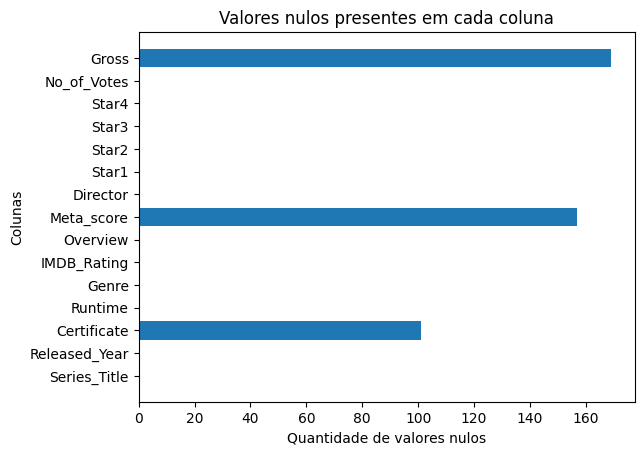

In [46]:
valores_nulos = filmes.isna().sum().reset_index()
valores_nulos.columns = ["colunas", "quant_nulos"]
fig, ax = plt.subplots()

ax.barh(valores_nulos["colunas"], valores_nulos["quant_nulos"], label=valores_nulos["colunas"])
ax.set_ylabel("Colunas")
ax.set_xlabel("Quantidade de valores nulos")
ax.set_title('Valores nulos presentes em cada coluna')
plt.show()

Preliminarmente a realização do tratamento de dados para os valores faltantes, outro ponto do dataframe será analisado, sendo ele a possível existência de *valores duplicados*. Abaixo tem-se essa verificação, a qual resultou em 0 valores duplicados, ou seja todos os elementos do dataframe são únicos.



In [47]:
filmes.duplicated().sum()

np.int64(0)

Portanto, seguindo para o tratamento dos valores ausentes das colunas: ***Gross, Meta_score e Certificate***, as seguintes etapas foram efetuadas:


1.   Pesquisa de dataframes que possuem as informações referentes a bilheteria, média de críticas e classificação etária.
2.   Extração dos dados necessários para completar o dataframe atual.
3.   Substituição dos valores austentes por valores extraídos na etapa anterior





In [48]:
#atualizando a coluna referente a bilheteria
dataset_bilheteria = pd.read_csv('arquivos/boxoffice_data_2024.csv', index_col=0)
filmes_sem_bilheteria = filmes.loc[filmes["Gross"].isna()]
filmes_bilheteria = dataset_bilheteria["Title"].to_list()
quant_sem_bilheteria = filmes_sem_bilheteria.shape[0]

for filme in filmes_sem_bilheteria["Series_Title"]:
  if(filme in filmes_bilheteria):
    bilheteria = dataset_bilheteria.loc[dataset_bilheteria["Title"] == filme].iloc[0]
    filmes.loc[filmes["Series_Title"] == filme, "Gross"] = bilheteria["Gross"].replace("$", "")

quant_add_bilheteria = quant_sem_bilheteria - filmes.loc[filmes["Gross"].isna()].shape[0]
print("A quantidade de filmes que obtiveram a atualização na bilheteria foi: " , quant_add_bilheteria)

A quantidade de filmes que obtiveram a atualização na bilheteria foi:  15


In [49]:
#atualizando a coluna referente a classificação etária
dataset_classificao = pd.read_csv('arquivos/final_dataset.csv', index_col="id")
filmes_sem_classificao = filmes.loc[filmes["Certificate"].isna()]
filmes_classificacao = dataset_classificao["title"].to_list()
quant_sem_classificacao = filmes_sem_classificao.shape[0]

for filme in filmes_sem_classificao["Series_Title"]:
  if(filme in filmes_classificacao):
    classificacao = dataset_classificao.loc[dataset_classificao["title"] == filme].iloc[0]
    filmes.loc[filmes["Series_Title"] == filme, "Certificate"] = classificacao["MPA"]

quant_add_classificacao = quant_sem_classificacao - filmes.loc[filmes["Certificate"].isna()].shape[0]
print("A quantidade de filmes que obtiveram a atualização na classificação foi: " , quant_add_classificacao)

A quantidade de filmes que obtiveram a atualização na classificação foi:  47


In [50]:
#atualizando a coluna referente a média ponderada das críticas
dataset_metascore= pd.read_csv('arquivos/movies.csv', index_col="id")
filmes_sem_metascore = filmes.loc[filmes["Meta_score"].isna()]
filmes_metascore = dataset_metascore["title"].to_list()
quant_sem_metascore = filmes_sem_metascore.shape[0]

for filme in filmes_sem_metascore["Series_Title"]:
  if(filme in filmes_metascore):
    metascore = dataset_metascore.loc[dataset_metascore["title"] == filme].iloc[0]
    metascore["metascore"] = metascore["metascore"].astype("int64")
    filmes.loc[filmes["Series_Title"] == filme, "Meta_score"] = metascore["metascore"]


quant_add_metascore = quant_sem_metascore - filmes.loc[filmes["Meta_score"].isna()].shape[0]
print("A quantidade de filmes que obtiveram a atualização na nota Meta Score foi: " , quant_add_metascore)

A quantidade de filmes que obtiveram a atualização na nota Meta Score foi:  15


É importante destacar que nem todos os valores ausentes foram substituídos por valores reais, visto que nos datasets mapeados alguns filmes não aparecem, logo para completar todos as linhas dos valores ausentes o mapeamento tem que ser ampliado para mais datasets.

Ademais, de acordo com a tabela apresentada anteriormente, observou-se que a maioria das colunas possuem elementos do tipo ***object***, ou seja são colunas que possuem valores diversificados. Para uma análise mais detalhada, essas colunas serão análisadas a seguir com o objetivo de verificar se o *tipo* pode ser modificado para outro que descreva melhor os valores da coluna.

Realizando uma análise superficial dos dados relacionados ao ano de lançamento do filmes, observou-se que apenas 1 filme não possuia o ano demarcado. Logo esse valor foi pesquisado individualmente para ser adicionado ao dataframe e assim tornar possível a conversão de todos os dados da coluna para int64 com o objetivo de facilitar as operações futuras.

In [51]:
index_filme = filmes.loc[-filmes["Released_Year"].str.isnumeric()].index
filmes.loc[index_filme[0], "Released_Year"] = 1995

filmes["Released_Year"] = filmes["Released_Year"].astype("int64")

Em relação a coluna "Series_Title" o tipo foi alterado para string.

In [52]:
filmes["Series_Title"] = filmes["Series_Title"].astype("string")


Por sua vez, para a coluna "Runtime" aplicou-se o código abaixo para facilitar as operações futuras.

In [53]:
filmes["Runtime"] = filmes["Runtime"].str.replace(" min", "").astype("int64")

Em relação as colunas de atores e diretores, o tipo foi modificado para string:

In [54]:
filmes["Star1"] = filmes["Star1"].astype("string")
filmes["Star2"] = filmes["Star2"].astype("string")
filmes["Star3"] = filmes["Star3"].astype("string")
filmes["Star4"] = filmes["Star4"].astype("string")
filmes["Director"] = filmes["Director"].astype("string")

As outras colunas também tiverem seu tipo modificado para o que foi presumido como o mais apropriado.

In [55]:
filmes["Certificate"] = filmes["Certificate"].astype("string")
filmes["Overview"] = filmes["Overview"].astype("string")
filmes["Gross"] = filmes["Gross"].str.replace(",", "").astype(float)
filmes["Genre"] = filmes["Genre"].astype("string")

Após a alteração de todos os tipos, seguiu-se com a ramificação da coluna "Genre" em mais de uma coluna, para facilitar as operações. Inicialmente determinou-se quantas colunas iriam ser criadas a partir da quantidade máxima de gêneros que um filme poderia ter, em seguida as novas colunas foram criadas e por fim a coluna "Genre" foi excluida. Ou seja, a formatação das colunas dos gêneros ficou semelhante das colunas referentes aos atores.

In [56]:
filmes["Genre"] = filmes["Genre"].str.split(",")
for i in range(1, filmes["Genre"].str.len().max()+1):
  filmes[f"Genre {i}"] = filmes["Genre"].str[i-1].astype("string").str.strip()

filmes.drop("Genre", axis=1, inplace=True);

O novo dataframe, alterado com o tratamento de dados foi salvo em um arquivo para ser utilizado nos modelos de previsão.

In [57]:
filmes.to_csv('arquivos/dataframe_modificado.csv')

Em seguida foi efetuado um resumo estatístico dos dados presentes no dataframe, no qual observou-se que:

*   O filme mais antigo da lista é do ano 1920, enquanto o mais atual é do ano 2020.
*   A maior parte dos filmes (75%) foram lançados antes de 2009.
*   O filme com menor duração tem 45 minutos, enquanto o com maior tem 321 minutos.
*   A maioria dos filmes possuem duração abaixo de 137 minutos.
*   A média de duração de todos os filmes do dataframe é aproximadamente 122 minutos.
*   A média das notas do site IMDB é 7.95, enquanto a média das nota do metascore é 77.89.
*   A maior nota do IMDB é 9.2 enquanto a menor é 7.6.
*   A maior nota do metascore é 100 enquanto a menor é 28.
*   Em relação as notas do IMDB a maior parte dos filmes estão abaixo de 8.1, enquanto nas notas do metascore a maioria dos filmes está abaixo de 87.
*   O filme com menor número de votos tem aproximadamente 25 088 votos enquanto o que possui mais votos tem 2 303 232.
*   A média de votos para todos os filmes foi 271 621.
*   A maior parte dos filmes tinha a quantidade de votos abaixo de 373 167.
*   Em relação a bilheteria a média geral foi 68 201 890.
*   O filme com menor bilheteria faturou 1305 dólares enquanto o com maior bilheteria faturou 936 662 200 dólares.
*   A maioria dos filmes teve um faturamento inferior a 82 418 500 dólares.

In [58]:
filmes.describe()

,Released_Year,Runtime,IMDB_Rating,Meta_score,No_of_Votes,Gross
count,999.000000,999.000000,999.000000,857.000000,9.990000e+02,8.450000e+02
mean,1991.218218,122.871872,7.947948,77.890315,2.716214e+05,6.820189e+07
std,23.297166,28.101227,0.272290,12.454201,3.209126e+05,1.091075e+08
min,1920.000000,45.000000,7.600000,28.000000,2.508800e+04,1.305000e+03
25%,1976.000000,103.000000,7.700000,70.000000,5.547150e+04,3.333969e+06
50%,1999.000000,119.000000,7.900000,79.000000,1.383560e+05,2.414963e+07
75%,2009.000000,137.000000,8.100000,87.000000,3.731675e+05,8.241850e+07
max,2020.000000,321.000000,9.200000,100.000000,2.303232e+06,9.366622e+08


Abaixo tem-se uma lista com perguntas gerais que podem ser extraídas dos dados apresentados no dataframe.

1. Qual o ator que mais aparece?
2. Qual o diretor que mais aparece?
3. Qual o gênero mais popular?
4. Qual o gênero que menos aparece?
5. A maioria dos filmes possui qual classificação etária?
6. Qual das classificações etárias é a menos popular?
7. Qual o filme com maior bilheteria?
8. Qual o filme com menor bilheteria?
9. Qual o filme com melhor nota (IMDB_Rating)?
10. Qual o filme com pior nota (IMDB_Rating)?
11. Qual o filme mais longo?
12. Qual o filme mais curto?
13. Qual filme com mais votos?
14. Qual o filme com menos votos?
15. Qual filme possui a melhor nota na coluna Meta_Score?
16. Qual filme possui a pior nota na coluna Meta_Score?
17. Qual ano lançou mais filmes?

Todas as respostas para as perguntas anteriores foram armazenadas em um dataframe que é exibido a seguir e informa os valores que possuem melhor indicadores, como nota ou popularidade.

In [59]:
#código para encontrar o ator mais popular
lista_atores = []

for i in range(1, 4):
  star = pd.DataFrame(filmes[f"Star{i}"].value_counts()).reset_index()
  star.columns = ["Ator", "Quantidade de filmes"]
  lista_atores.append(star)

atores_dataframe = pd.concat(lista_atores)
atores_popularidade = atores_dataframe.groupby("Ator").sum()
atores_popularidade = atores_popularidade.sort_values(by="Quantidade de filmes", ascending=False).reset_index()


#código para encontrar o gênero mais popular
lista_generos = []

for i in range(1, 3):
  genre = pd.DataFrame(filmes[f"Genre {i}"].value_counts()).reset_index()
  genre.columns = ["Gênero", "Quantidade de filmes"]
  lista_generos.append(genre)

generos_dataframe = pd.concat(lista_generos)
generos_popularidade = generos_dataframe.groupby("Gênero").sum()
generos_popularidade = generos_popularidade.sort_values(by="Quantidade de filmes", ascending=False).reset_index()


melhor_ator = atores_popularidade["Ator"].iloc[0]
melhor_diretor = filmes["Director"].value_counts().index[0]
genero_popular = generos_popularidade["Gênero"].iloc[0]
genero_impopular = generos_popularidade["Gênero"].iloc[-1]
pop_classificacao = filmes["Certificate"].value_counts().index[0]
imp_classificacao = filmes["Certificate"].value_counts().index[-1]
melhor_bilheteria = filmes.loc[filmes["Gross"] == filmes["Gross"].max()]["Series_Title"].iloc[0]
pior_bilheteria = filmes.loc[filmes["Gross"] == filmes["Gross"].min()]["Series_Title"].iloc[0]
melhor_nota = filmes.loc[filmes["IMDB_Rating"] == filmes["IMDB_Rating"].max()]["Series_Title"].iloc[0]
pior_nota = filmes.loc[filmes["IMDB_Rating"] == filmes["IMDB_Rating"].min()]["Series_Title"].iloc[0]
maior_votos = filmes.loc[filmes["No_of_Votes"] == filmes["No_of_Votes"].max()]["Series_Title"].iloc[0]
menor_votos = filmes.loc[filmes["No_of_Votes"] == filmes["No_of_Votes"].min()]["Series_Title"].iloc[0]
meta_melhor = filmes.loc[filmes["Meta_score"] == filmes["Meta_score"].max()]["Series_Title"].iloc[0]
meta_pior = filmes.loc[filmes["Meta_score"] == filmes["Meta_score"].min()]["Series_Title"].iloc[0]
ano_popular = filmes["Released_Year"].value_counts().index[0]
filme_longo = filmes.loc[filmes["Runtime"] == filmes["Runtime"].max()]["Series_Title"].iloc[0]
filme_curto = filmes.loc[filmes["Runtime"] == filmes["Runtime"].min()]["Series_Title"].iloc[0]

maiores = [melhor_diretor, melhor_ator, melhor_nota, maior_votos, meta_melhor, filme_longo, ano_popular, genero_popular, pop_classificacao, melhor_bilheteria]
menores = ["", "", pior_nota, menor_votos, meta_pior, filme_curto, "", genero_impopular, imp_classificacao, pior_bilheteria]

maiores_menores = pd.DataFrame(
    {"Valores Maiores": maiores, "Valores menores": menores},
    index=["Diretor",
           "Ator",
           "Nota IMDB",
           "Quantidade de votos",
           "Nota Meta Score",
           "Duração",
           "Ano de lançamento",
           "Gênero",
           "Classificação etária",
           "Bilheteria"])

maiores_menores

,Valores Maiores,Valores menores
Diretor,Alfred Hitchcock,
Ator,Robert De Niro,
Nota IMDB,The Godfather,Dark Waters
Quantidade de votos,The Dark Knight,Ba wang bie ji
Nota Meta Score,The Godfather,I Am Sam
Duração,Gangs of Wasseypur,Sherlock Jr.
Ano de lançamento,2014,
Gênero,Drama,Musical
Classificação etária,U,U/A
Bilheteria,Star Wars: Episode VII - The Force Awakens,Adams æbler


É importante destacar que na tabela acima algumas variáveis não possuem um valor definido, como Diretor e Ator, visto que vários diretores e atores aprecem uma única vez no dataframe, então não faria sentido adicionar várias pessoas, pois o objetivo era encontrar ***apenas um valor*** que se destaca, seja em relação a notas ou a popularidade.

Reflexões que podem ser assumidas a partir da análise inicial dos valores em destaque.


*   O diretor mais popular é o Alfred Hitchcock e o ator é o Robert De Niro.
*   A nota do IMDB ***talvez*** possui relação com a nota do MetaScore, visto que o filme com melhor avaliação em ambos é The Godfather.
*   Existem vários filmes lançados em 2014 na lista.
*   O gênero mais popular é drama enquanto o menor popular é Thriller.
*   A maioria dos filmes possuem classificação Universal.
*   Star Wars: Episode VII - The Force Awakens foi o filme com maior bilheteria.



Ademais, os gráficos abaixo indicam a variação das notas do Metascore e do IMDB. Observa-se no gráfico referente as notas do IMDB que não existe uma grande variabilidade dos dados, além de poucos outliers concentrados nas notas altas. Enquanto no gráfico das notas do metascore existem outliers em relação as notas mais baixas, mas a pouco variabilidade também é presente. A principal diferença é em relação a concentração dos valores, visto que as notas do IMDB se concentram entre 7.6 e 8.2 enquanto as notas do metascore se concentram entre 70 e 90.

Essas diferenças, seja no intervalo geral ou no intervalo de concentração atrapalham um pouco a análise do sucesso de um filmes, pois se a diferença entre a nota do metascore e do imdb para o mesmo filme for significativa existe um impasse, qual das variáveis representa a verdade? Para resolver esse problema é indicado que as notas não sejam observadas sozinhas para conclusões importantes, mas em conjunto com bilheteria, número de votos etc.

O terceiro apresenta um violinplot que exibe a densidade de filmes que possuem notas muito discrepantes entre o metascore e o imdb. Apesar de a maior parte das diferenças estarem concentradas entre 0 e 10, ainda existem ocorrências na qual a diferença entre as duas notas pode chegar a 50, o que pode se tornar alarmente durante a modelagem, visto que o Meta_score é uma das variáveis utilizadas para prever a nota do IMDB.

Por fim, finalizando os gráficos referentes as notas, existem 3 gráficos, os dois primeiros para as notas imdb e do metascore, que relacionam a variação das notas no decorrer das décadas. Através desses gráficos, observa-se que os filmes mais antigos conseguiam obter notas maiores, no entanto deve-se levar em consideração que a maioria dos filmes presentes no datasets datam de décadas mais recentes, como está exibido no gráfico que apresenta a distribuição de filmes por décadas. Logo, as notas "melhores" dos filmes antigos é um dado inconclusivo visto que para essa observação ser verdadeira seriam necessários mais dados.

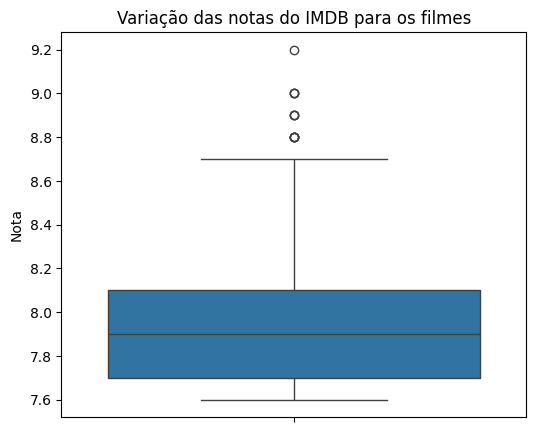

In [60]:
plt.figure(figsize=(6,5))
sns.boxplot(y=filmes['IMDB_Rating'])
plt.title("Variação das notas do IMDB para os filmes")
plt.ylabel("Nota")
plt.show()

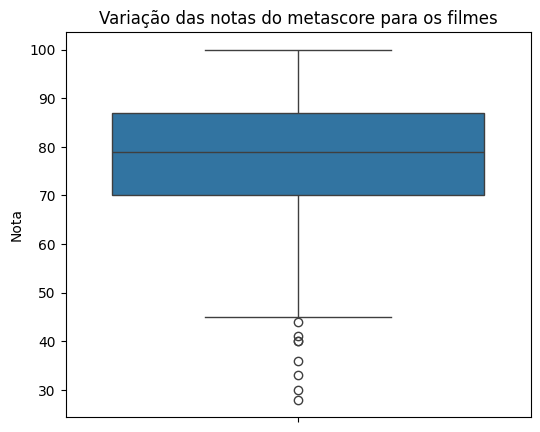

In [61]:
plt.figure(figsize=(6,5))
sns.boxplot(y=filmes['Meta_score'])
plt.title("Variação das notas do metascore para os filmes")
plt.ylabel("Nota")
plt.show()

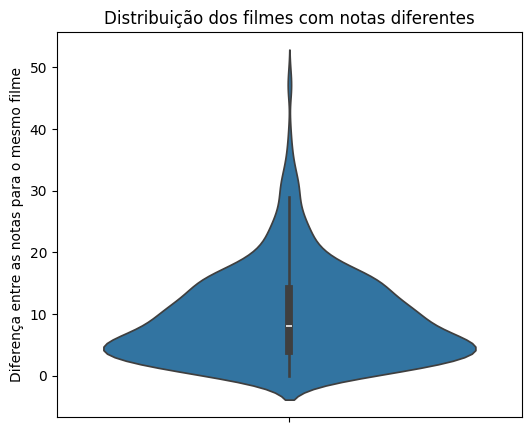

In [62]:
filmes["Diferenca_imdb/metascore"] = (filmes["IMDB_Rating"]*10 - filmes["Meta_score"]).abs()

plt.figure(figsize=(6,5))
sns.violinplot(y=filmes['Diferenca_imdb/metascore'])
plt.title("Distribuição dos filmes com notas diferentes")
plt.ylabel("Diferença entre as notas para o mesmo filme")
plt.show()

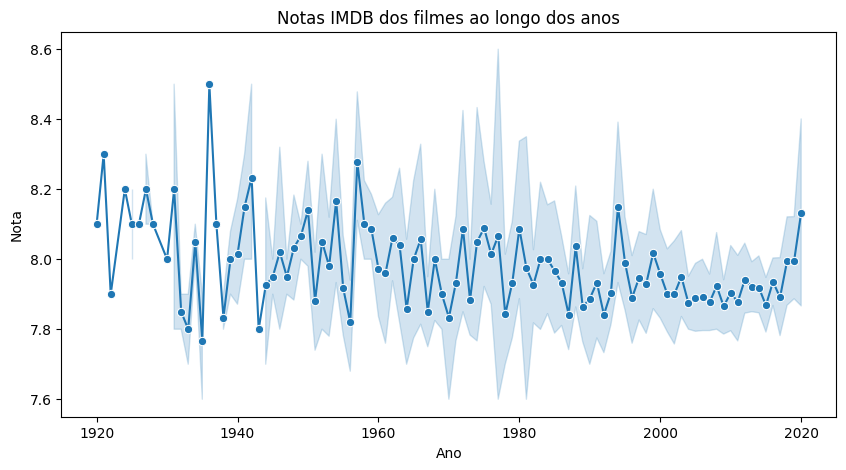

In [63]:
plt.figure(figsize=(10,5))
sns.lineplot(x='Released_Year', y='IMDB_Rating', data=filmes, marker='o')
plt.title("Notas IMDB dos filmes ao longo dos anos")
plt.xlabel("Ano")
plt.ylabel("Nota")
plt.show()

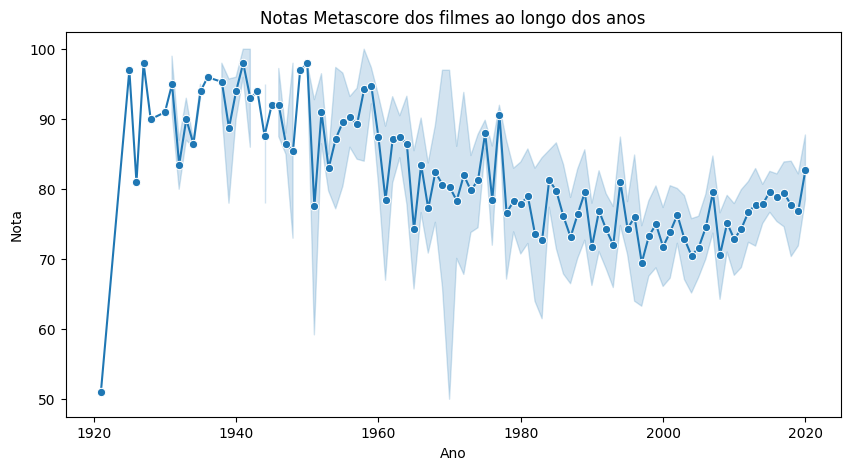

In [64]:
plt.figure(figsize=(10,5))
sns.lineplot(x='Released_Year', y='Meta_score', data=filmes, marker='o')
plt.title("Notas Metascore dos filmes ao longo dos anos")
plt.xlabel("Ano")
plt.ylabel("Nota")
plt.show()

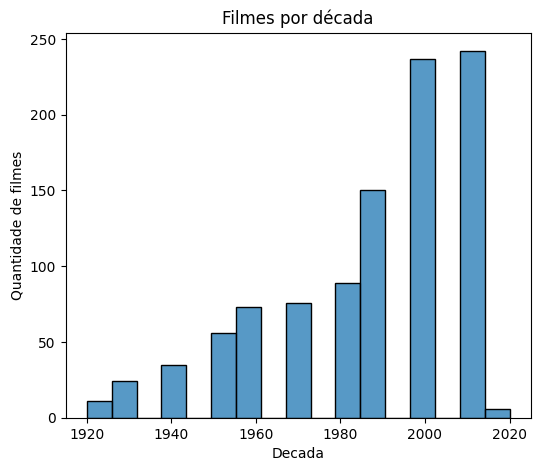

In [65]:
filmes["Decada"] = (filmes["Released_Year"]//10)*10

plt.figure(figsize=(6,5))
sns.histplot(x=filmes['Decada'])
plt.title("Filmes por década")
plt.ylabel("Quantidade de filmes")
plt.show()

O faturamento dos filmes é determinado pela coluna "Gross", logo o gráfico abaixo apresenta a distribuição da bilheteria que os filmes do dataset tiveram. Observa-se que a maioria dos filmes arrecadou entre 1 a 200 milhões de dólares e que apenas alguns outliers conseguiram números expressivos, além dos 400 milhões de dólares.

Além disso, também tem-se um gráfico que relaciona as décadas que os filmes foram lançados e a bilheteria que eles arrecadaram, comprovando que os valores de bilheteria tendem a aumentar com o passar dos anos.

E por fim, outra análise gráfica que é importante, é a de bilheteria com notas IMDB e Metascore. Enquanto o primeiro gráfico exibe a relação com as notas do IMDB, que apresentam um padrão claro crescendo com a bilheteria, o segundo gráfico exibe a relação com as notas do Metascore, que não apresentam nenhum padrão fixo, pelo contrário não é possível supor observações relevantes ao observar esse gráfico.

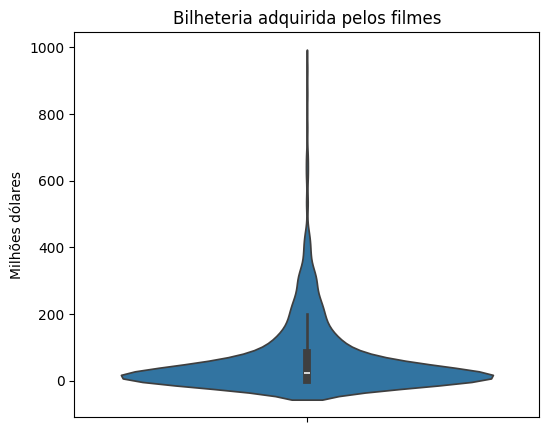

In [66]:
plt.figure(figsize=(6,5))
sns.violinplot(y=filmes['Gross']/1000000)
plt.title("Bilheteria adquirida pelos filmes")
plt.ylabel("Milhões dólares")
plt.show()

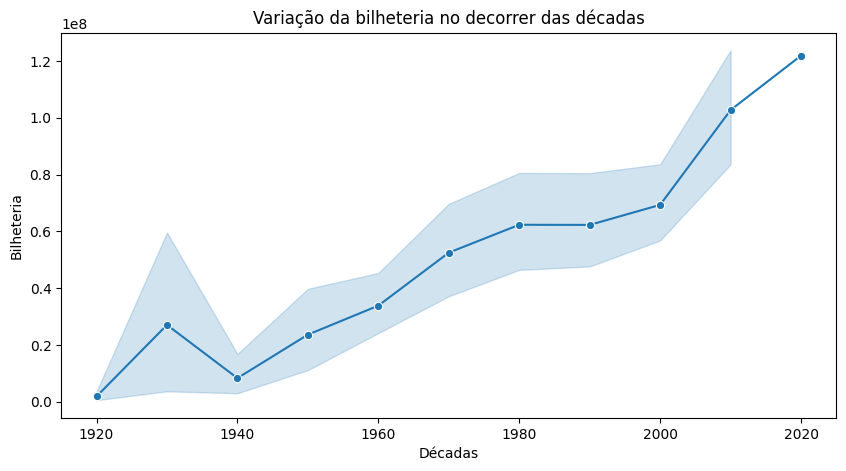

In [67]:
plt.figure(figsize=(10,5))
sns.lineplot(x='Decada', y='Gross', data=filmes, marker='o')
plt.title("Variação da bilheteria no decorrer das décadas")
plt.xlabel("Décadas")
plt.ylabel("Bilheteria")
plt.show()

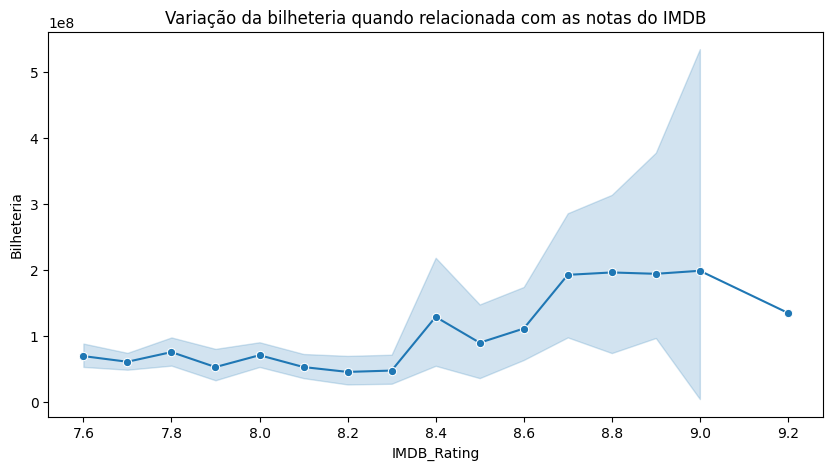

In [68]:
plt.figure(figsize=(10,5))
sns.lineplot(x='IMDB_Rating', y='Gross', data=filmes, marker='o')
plt.title("Variação da bilheteria quando relacionada com as notas do IMDB")
plt.xlabel("IMDB_Rating")
plt.ylabel("Bilheteria")
plt.show()

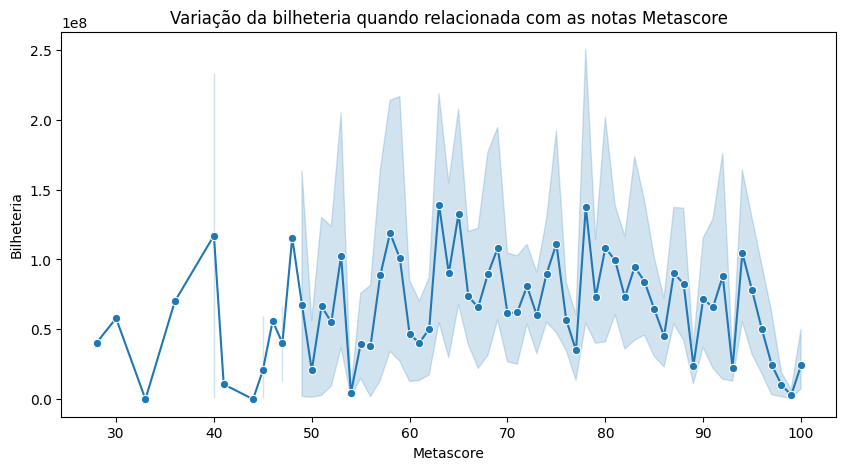

In [69]:
plt.figure(figsize=(10,5))
sns.lineplot(x='Meta_score', y='Gross', data=filmes, marker='o')
plt.title("Variação da bilheteria quando relacionada com as notas Metascore")
plt.xlabel("Metascore")
plt.ylabel("Bilheteria")
plt.show()

Finalizando a análise tem-se os gráficos relacionados aos atores, diretores, gêneros e classificação indicativa. Em relação aos atores e diretores, a tabela abaixo apresenta os seis atores e diretores mais populares, enquanto a segunda tabela apresenta os diretores que possuem a melhor média em relação as notas IMDB dos filmes que participaram.

In [70]:
valores = filmes["Director"].value_counts().head(6).reset_index()
valores = valores.join(atores_popularidade.head(6))
valores.columns.values[3] = "Quantidade de filmes"
valores

,Director,count,Ator,Quantidade de filmes
0,Alfred Hitchcock,14,Robert De Niro,17
1,Steven Spielberg,13,Tom Hanks,14
2,Hayao Miyazaki,11,Al Pacino,13
3,Martin Scorsese,10,Clint Eastwood,12
4,Akira Kurosawa,10,Leonardo DiCaprio,11
5,Billy Wilder,9,Christian Bale,11


In [71]:
diretores_top20 = filmes["Director"].value_counts().head(20).reset_index()
lista_diretores = diretores_top20["Director"].to_list()
media_diretores = filmes.loc[filmes["Director"].isin(lista_diretores)]
media_diretores = media_diretores.groupby("Director")["IMDB_Rating"].mean()
media_diretores.reset_index()

,Director,IMDB_Rating
0,Akira Kurosawa,8.220000
1,Alfonso Cuarón,7.750000
2,Alfred Hitchcock,8.007143
3,Billy Wilder,8.144444
4,Charles Chaplin,8.333333
5,Christopher Nolan,8.462500
6,Clint Eastwood,7.912500
7,David Fincher,8.037500
8,Hayao Miyazaki,8.018182
9,Howard Hawks,7.857143


Abaixo tem-se um gráfico representando a distribuição dos 10 gêneros mais populares na tabela, seguido por um gráfico apresentando os gêneros mais populares em relação a bilheteria.

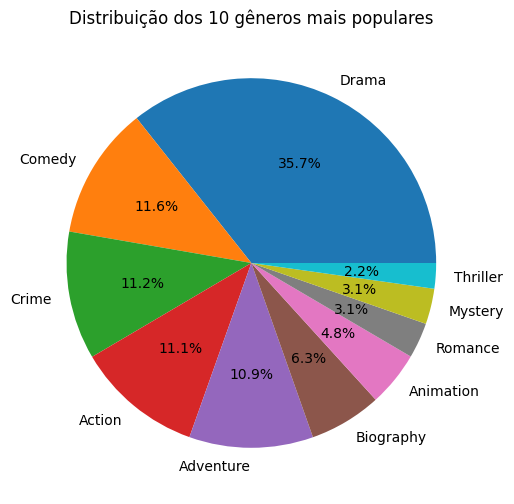

In [72]:
generos_pizza = generos_popularidade

plt.figure(figsize=(6,6))
plt.pie(generos_pizza['Quantidade de filmes'].head(10), labels=generos_pizza["Gênero"].head(10), autopct='%1.1f%%')
plt.title("Distribuição dos 10 gêneros mais populares")
plt.show()


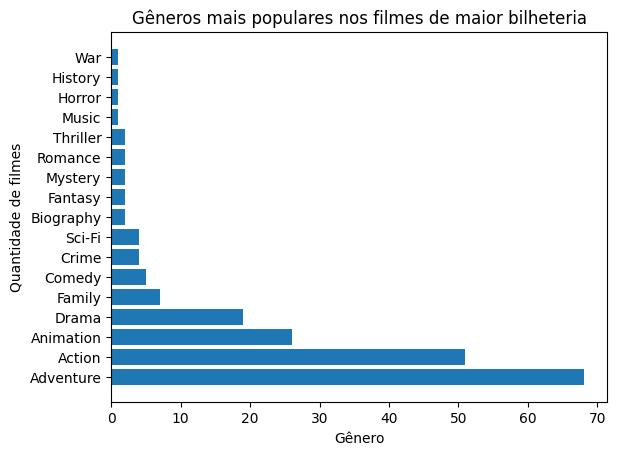

In [73]:
bilheteria_maiores = filmes.loc[filmes["Gross"].sort_values(ascending=False).index].head(100)
generos_bilheteria = []

for i in range(1, 3):
  genre = pd.DataFrame(bilheteria_maiores[f"Genre {i}"].value_counts()).reset_index()
  genre.columns = ["Gênero", "Quantidade de filmes"]
  generos_bilheteria.append(genre)

gen_bilheteria_dataframe = pd.concat(generos_bilheteria)
generos_pop_bilheteria = gen_bilheteria_dataframe.groupby("Gênero").sum()
generos_pop_bilheteria = generos_pop_bilheteria.sort_values(by="Quantidade de filmes", ascending=False).reset_index()

fig, ax = plt.subplots()

ax.barh(generos_pop_bilheteria["Gênero"], generos_pop_bilheteria["Quantidade de filmes"], label=generos_pop_bilheteria["Gênero"])
ax.set_ylabel("Quantidade de filmes")
ax.set_xlabel("Gênero")
ax.set_title('Gêneros mais populares nos filmes de maior bilheteria')
plt.show()

### **Análise exploratória de dados**

Inicialmente examinei a relação que todas as variáveis/colunas possuem entre elas mesmas.

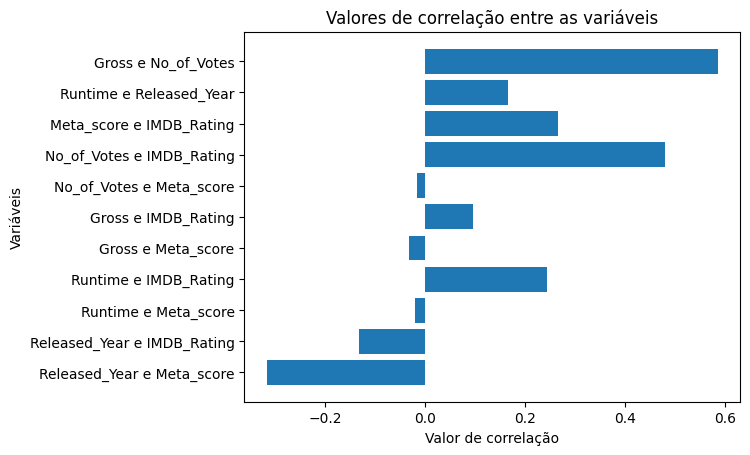

In [74]:
ano_metascore = filmes["Released_Year"].corr(filmes["Meta_score"])
ano_imdb = filmes["Released_Year"].corr(filmes["IMDB_Rating"])

rtime_metascore = filmes["Runtime"].corr(filmes["Meta_score"])
rtime_imdb = filmes["Runtime"].corr(filmes["IMDB_Rating"])

box_metascore = filmes["Gross"].corr(filmes["Meta_score"])
box_imdb = filmes["Gross"].corr(filmes["IMDB_Rating"])

votes_metascore = filmes["No_of_Votes"].corr(filmes["Meta_score"])
votes_imdb = filmes["No_of_Votes"].corr(filmes["IMDB_Rating"])

imdb_metascore = filmes["Meta_score"].corr(filmes["IMDB_Rating"])
runtime_ano = filmes["Runtime"].corr(filmes["Released_Year"])
box_votes = filmes["Gross"].corr(filmes["No_of_Votes"])

dados_correlacao = pd.DataFrame({"Variáveis": ["Released_Year e Meta_score",
                                                "Released_Year e IMDB_Rating",
                                               "Runtime e Meta_score",
                                               "Runtime e IMDB_Rating",
                                               "Gross e Meta_score",
                                               "Gross e IMDB_Rating",
                                               "No_of_Votes e Meta_score",
                                               "No_of_Votes e IMDB_Rating",
                                               "Meta_score e IMDB_Rating",
                                               "Runtime e Released_Year",
                                               "Gross e No_of_Votes"
                                               ],"Valores de correlação": [
                                                   ano_metascore, ano_imdb,
                                                   rtime_metascore, rtime_imdb,
                                                   box_metascore, box_imdb,
                                                   votes_metascore, votes_imdb,
                                                   imdb_metascore, runtime_ano,
                                                   box_votes
                                               ]})

fig, ax = plt.subplots()

ax.barh(dados_correlacao["Variáveis"], dados_correlacao["Valores de correlação"], label=dados_correlacao["Variáveis"])
ax.set_ylabel("Variáveis")
ax.set_xlabel("Valor de correlação")
ax.set_title('Valores de correlação entre as variáveis')
plt.show()

Observando o histograma notou-se que ["Gross" e "No_of_Votes"] e ["No_of_Votes" e "IMDB_Rating"] possuiam um valor de correlação significativo, portanto conclui-se que quanto maior a bilheteria de um filme maior o número de votos que ele terá no site IMDB e quanto maior o número de votos maior é a nota no IMDB. Em relação as outras variáveis, visto que os valores de correlação foram irrelevantes conclui-se que não é possível dizer se existe ou não alguma correspondência entre elas.

Perguntas do relatório:

***Qual filme você recomendaria para uma pessoa que você não conhece?***

  Como é alguém que eu não conheço, não tenho como supor suas preferências, então eu focaria nos 10 filmes com melhor nota e escolheria aquele com maior bilheteria e maior número de votos, pois as chances de um filme que foi popular entre uma grande massa de pessoas agradar alguém desconhecido do que um filme de nincho. Logo, o filme escolhido foi o Poderoso Chefão, o código dessa análise está exibido nas próximas células.

***Quais são os principais fatores que estão relacionados com alta expectativa de faturamento de um filme?***

  A coluna referente a faturamento é Gross, então eu analisei qual das outras variáveis melhor se relacionava com ela através do cálculo da correlação. E através dos valores adquiridos as variáveis que mais se destacaram foram:
  ***[No_of_Votes, Released_Year, Certificate, Runtime, IMDB_Rating, Meta_score]***.
  Já se esperava o número de votos como variável significativa, visto que um filme com grande faturamento/bilheteria também é popular online entre o público. As outras variáveis demonstraram que filmes com um público universal (a maior parte dos valores de Certificate na tabela tinham essa classificação etária) também são os mais possíveis de ter um alto lucro, o que faz sentido pois o público para comprar ingressos é mais amplo e ilimitado. Também pode-se supor através dos dados que filmes de maior duração são mais aceitos pelo público do que longas menores. E por fim, tem-se as variáveis referentes a nota dos críticos e do público que também influênciam na popularidade e consequentemente no faturamento de um filme.

***Quais insights podem ser tirados com a coluna Overview? É possível inferir o gênero do filme a partir dessa coluna?***

  Palavras-chaves, como "fight", "journey", "journey", "suspense", "technology" e "mystery", poderiam ajudar a prever os temas e o gênero do filme. Uma das abordagens que poderia ser utilizada é com modelos de processamento de linguagem natural, na qual para extrair o máximo dos dados deveria ser realizada uma limpeza do texto, como remover pontuação e stopword, seguida por uma separação das palavras e lemmatização, e finalizando com uma extração de features.


O código abaixo apresenta uma tabela com os 10 filmes com melhores notas e bilheteria, os quais são os filmes que eu recomendaria para um estranho.

In [75]:
notas_imdb = filmes["IMDB_Rating"].sort_values(ascending=False).head(300).index
notas = filmes["Meta_score"].dropna().sort_values(ascending=False).head(300).index
bilh_filmes = filmes["Gross"].dropna().sort_values(ascending=False).head(300).index
votos_filmes = filmes["No_of_Votes"].sort_values(ascending=False).head(300).index

indices_comuns = notas_imdb.intersection(notas).intersection(bilh_filmes).intersection(votos_filmes).sort_values(ascending=True)
filmes.loc[indices_comuns[:10]]

,Series_Title,Released_Year,Certificate,Runtime,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,Genre 1,Genre 2,Genre 3,Diferenca_imdb/metascore,Decada
1,The Godfather,1972,A,175,9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.0,Crime,Drama,<NA>,8.0,1970
3,The Godfather: Part II,1974,A,202,9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57300000.0,Crime,Drama,<NA>,0.0,1970
5,The Lord of the Rings: The Return of the King,2003,U,201,8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,377845905.0,Action,Adventure,Drama,5.0,2000
6,Pulp Fiction,1994,A,154,8.9,"The lives of two mob hitmen, a boxer, a gangst...",94.0,Quentin Tarantino,John Travolta,Uma Thurman,Samuel L. Jackson,Bruce Willis,1826188,107928762.0,Crime,Drama,<NA>,5.0,1990
7,Schindler's List,1993,A,195,8.9,"In German-occupied Poland during World War II,...",94.0,Steven Spielberg,Liam Neeson,Ralph Fiennes,Ben Kingsley,Caroline Goodall,1213505,96898818.0,Biography,Drama,History,5.0,1990
10,The Lord of the Rings: The Fellowship of the Ring,2001,U,178,8.8,A meek Hobbit from the Shire and eight compani...,92.0,Peter Jackson,Elijah Wood,Ian McKellen,Orlando Bloom,Sean Bean,1661481,315544750.0,Action,Adventure,Drama,4.0,2000
13,The Lord of the Rings: The Two Towers,2002,UA,179,8.7,While Frodo and Sam edge closer to Mordor with...,87.0,Peter Jackson,Elijah Wood,Ian McKellen,Viggo Mortensen,Orlando Bloom,1485555,342551365.0,Action,Adventure,Drama,0.0,2000
19,Gisaengchung,2019,A,132,8.6,Greed and class discrimination threaten the ne...,96.0,Bong Joon Ho,Kang-ho Song,Lee Sun-kyun,Cho Yeo-jeong,Choi Woo-sik,552778,53367844.0,Comedy,Drama,Thriller,10.0,2010
24,Saving Private Ryan,1998,R,169,8.6,"Following the Normandy Landings, a group of U....",91.0,Steven Spielberg,Tom Hanks,Matt Damon,Tom Sizemore,Edward Burns,1235804,216540909.0,Drama,War,<NA>,5.0,1990
28,The Silence of the Lambs,1991,A,118,8.6,A young F.B.I. cadet must receive the help of ...,85.0,Jonathan Demme,Jodie Foster,Anthony Hopkins,Lawrence A. Bonney,Kasi Lemmons,1270197,130742922.0,Crime,Drama,Thriller,1.0,1990


Abaixo tem-se o código do valor de correlação entre a variável Gross e as demais, no qual é exibido uma tabela com as 6 principais variáveis.

In [76]:
filmes_corr = filmes.dropna()
le = LabelEncoder()
filmes_corr.Certificate = le.fit_transform(filmes_corr.Certificate)
filmes_corr.Director = le.fit_transform(filmes_corr.Director)
filmes_corr.Star1 = le.fit_transform(filmes_corr.Star1)
filmes_corr.Star2 = le.fit_transform(filmes_corr.Star2)
filmes_corr.Star3 = le.fit_transform(filmes_corr.Star3)
filmes_corr.Star4 = le.fit_transform(filmes_corr.Star4)
filmes_corr["Genre 1"] = le.fit_transform(filmes_corr["Genre 1"])
filmes_corr["Genre 2"] = le.fit_transform(filmes_corr["Genre 2"])
filmes_corr["Genre 3"] = le.fit_transform(filmes_corr["Genre 3"])

correlacao_gross = filmes_corr[['Released_Year', 'Certificate', 'Runtime',
       'IMDB_Rating', 'Meta_score', 'Director', 'Star1', 'Star2',
       'Star3', 'Star4', 'No_of_Votes', 'Genre 1', 'Genre 2',
       'Genre 3']].corrwith(filmes_corr['Gross'])
correlacao_gross.sort_values(ascending=False).head(6).reset_index()

,index,0
0,No_of_Votes,0.592984
1,Released_Year,0.290626
2,Certificate,0.218215
3,Runtime,0.165664
4,IMDB_Rating,0.163753
5,Meta_score,0.023804


### **Etapa de previsão de notas**

A etapa de modelagem foi construída com o objetivo de **prever a nota do imdb** a partir dos dados. Logo, algumas questões devem ser respondidas:



***Quais foram as variáveis utilizadas e por quê?***

  As variáveis finais escolhidas foram ***["Meta_score", "No_of_Votes", "Gross", "Runtime"]***. Inicialmente quando estava trabalhando com ambos os algoritmos todas as variáveis estavam aplicadas no modelo ***["Certificate", "Runtime", "Meta_score", "Director", "Star1", "Star2","Star3", "Star4", "No_of_Votes", "Gross", "Genre 1", "Genre 2", "Genre 3"]*** e através dos resultados que encontrava a cada iteração e de avaliações realizadas com o auxílio do *feature importance* e valores de correlação ajustava-se o conjunto de variáveis , até que chegou-se no conjunto ***["Meta_score", "No_of_Votes", "Gross", "Runtime"]***.

***Qual o tipo de problema que essa modelagem trabalha? Regressão ou Classificação?***

  É um problema de regressão, visto que a variável que vai ser prevista é numerica, ou seja um valor contínuo.

***Qual modelo se aproxima melhor dos dados e quais são os prós e contras?***

  Existem diversas possibilidades de modelos, porém foram escolhidos dois modelos: o ***Random Forest*** e o ***Gradient Boosting***. O primeiro é um algoritmo que costuma ter um bom desempenho, possui um risco de overfitting menor e fornece métricas que auxiliam a entender quais variáveis são mais relevantes. Porém, também existem fatores desfavoráveis pois é um algoritmo mais lento que consume mais memória. Já o segundo, possui como vantagens a alta perfomance, a flexibilidade e o auxílio para identificar quais variáveis mais impactam o modelo. Em relação as desvantagens, o tempo de treinamento do segundo algoritmo é maior, é menos paralelizável e também é sensível a hiperparâmetros.


***Qual medida de perfomance do modelo foi escolhida e por quê?***

  Métrica RSME, que significa Root Mean Squared Error, e MAE, que significa Mean Absolute Error. Escolhi os dois para ter uma visão mais ampla e detalhada do que o algoritmo está entregando, visto que enquanto o RSME auxilia a evitar que as previsões fiquem muito distantes da realiade, o MAE mede o erro médio absoluto de maneira mais geral.



O código abaixo apresenta os dois modelos já treinados e os resultados das notas em cada modelo.

In [93]:
filme_test = pd.DataFrame([{"Meta_score": 80.0, "No_of_Votes": 2343110, "Gross": 28341469, "Runtime": 142}])

#lendo o arquivo do modelo gradient boosting
with open("modelagem/gradient_boosting.pkl", "rb") as f:
    modelo_gradient = pickle.load(f)

#usando o modelo
nota_pred = modelo_gradient.predict(filme_test)

print(f"Modelo Gradient Boosting: {nota_pred}");

#lendo o arquivo do modelo random forest
with open("modelagem/random_forest.pkl", "rb") as f:
    modelo_random_forest = pickle.load(f)

#usando o modelo
nota_pred2 = modelo_random_forest.predict(filme_test)

print(f"Modelo Random Forest: {nota_pred2}");

Modelo Gradient Boosting: [8.66399531]
Modelo Random Forest: [8.403]


### Resultados e Conclusões

Inicialmente eu pretendia trabalhar apenas com um modelo, que era o Random Forest, no entanto durante meus testes iniciais e com os resultados apresentados, achei que seria melhor adicionar outro modelo para comparar as notas e as métricas, e o escolhido foi o Gradient Boosting.

O modelo que foi desenvolvido ainda está em desenvolvimento, visto que os dados disponibilizados, apesar de enriquecedores, possuem limitações que dificultam para o modelo realizar previsões mais exatas. No entanto, acredito que com o acréscimo de mais alguns dados adquiridos a partir de outros datasets externos o modelo melhore e se torne cada vez mais confiável.

No geral, o projeto tinha como principal objetivo auxiliar produtores a encontrar padrões para filmes lucrativos, desse modo tem-se a seguir algumas observações que foram adquiridas através dos dados:

* Um filme com classificação etária universal.
* Um filme com duração média de 120 minutos.
* Um filme com um ou mais dos seguintes gêneros: Aventura, Ação, Animação.
* Se possível colocar o Christopher Nolan para dirigir o filme, pois além de ser uma força na crítica também se mostrou uma força em bilheteria e público online (possui o filme com mais votos).
* As notas do metascore não refletem tanto em bilheteria ou lucro, visto que estão relacionadas com a crítica e em algumas situações diferem da opinião do público, exibido nas notas do IMDB, então o foco tem que estar no que o público quer.